In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
from scipy.spatial.distance import pdist, squareform
from scipy.fftpack import fft
from sklearn.manifold import MDS
from sklearn.neighbors import NearestNeighbors

In [3]:
#making time series dataframe from unsupervised data, index is timestamp.

data = pd.read_csv(r"path/of/data.csv", parse_dates=['time'] , index_col='time')
data.drop(data.columns[0],axis=1,inplace=True)
#print(data.head())

In [4]:
#selecting important attributes(i.e input and output variables).

input_variables = ['kilnMainDriveCurrent',
                   'kilnRPM',
                   'kilnFeed',
                   'calcinerCoal',
                   'preHeaterFanRPM',
                   'mainBurnerCoal']

output_variables = ['kilnInletO2',
                    'kilnInletTemperature',
                    'kilnInletNOx',
                    'sinteringZoneTemperature(MainBurnerTemperature)']

df = data[input_variables + output_variables]
print(df.head())

                     kilnMainDriveCurrent   kilnRPM    kilnFeed  calcinerCoal  \
time                                                                            
2020-09-15 00:00:58            935.763916  4.731806  492.954285     15.048611   
2020-09-15 00:00:59            938.368103  4.728172  492.578125     15.048611   
2020-09-15 00:01:00            935.763916  4.728172  492.578125     15.058160   
2020-09-15 00:01:01            929.253479  4.731806  492.954285     15.077257   
2020-09-15 00:01:02            925.347229  4.731806  493.142365     15.067708   

                     preHeaterFanRPM  mainBurnerCoal  kilnInletO2  \
time                                                                
2020-09-15 00:00:58       636.574097       12.919271     0.622106   
2020-09-15 00:00:59       636.284729       12.928820     0.643808   
2020-09-15 00:01:00       636.574097       12.928820     0.679977   
2020-09-15 00:01:01       636.574097       12.919271     0.672743   
2020-09-15 00:01:0

In [5]:
#Using interpolation to manage NaN values(otherwise it will lead to unnecessarily high frequencies in the frequency spectrum)

flag1 = (df.isna().sum() / df.shape[0]) * 100
print(flag1)

print('--------------------------INTERPOLATION-------------------------------------')

df = df.interpolate(method='linear', limit_direction='forward', axis=0)
flag2 = (df.isna().sum() / df.shape[0]) * 100
print(flag2)

kilnMainDriveCurrent                               24.998108
kilnRPM                                            24.998108
kilnFeed                                           24.998424
calcinerCoal                                       24.998424
preHeaterFanRPM                                    24.998424
mainBurnerCoal                                     24.998424
kilnInletO2                                        24.998424
kilnInletTemperature                               24.998424
kilnInletNOx                                       24.998424
sinteringZoneTemperature(MainBurnerTemperature)    24.998424
dtype: float64
--------------------------INTERPOLATION-------------------------------------
kilnMainDriveCurrent                               0.0
kilnRPM                                            0.0
kilnFeed                                           0.0
calcinerCoal                                       0.0
preHeaterFanRPM                                    0.0
mainBurnerCoal         

In [6]:
# Detection in one feature(kilnInletNOx)

attri = df.columns[8]

df_1 = df.groupby(pd.Grouper(freq = "60min")).apply(lambda x: x[attri].values if len(x[attri].values) == int(pd.Timedelta('60min').total_seconds()) else np.nan)
df_1 = df_1.dropna()
df_1.head()


time
2020-09-15 01:00:00    [10.9697980880737, 11.165135383606, 11.3418684...
2020-09-15 02:00:00    [358.884613037109, 360.460754394531, 361.74899...
2020-09-15 03:00:00    [281.95196533203097, 282.036682128906, 282.044...
2020-09-15 04:00:00    [135.024887084961, 134.841735839844, 134.67604...
2020-09-15 05:00:00    [147.28845214843798, 135.947830200195, 125.273...
dtype: object

In [7]:
## Apply FFT followed by calculation of pairwise distance between magnitude 
## of FFT coefficients of each sample
fftmag =  np.abs(np.array([fft(x) for x in df_1.values]))
df_dist = pd.DataFrame(squareform(pdist(np.abs(fftmag), 'euclidean')))
df_dist.index = df_1.index.copy()
df_dist.columns = df_1.index.copy()
df_dist.head()

time,2020-09-15 01:00:00,2020-09-15 02:00:00,2020-09-15 03:00:00,2020-09-15 04:00:00,2020-09-15 05:00:00,2020-09-15 06:00:00,2020-09-15 07:00:00,2020-09-15 08:00:00,2020-09-15 09:00:00,2020-09-15 10:00:00,...,2020-11-28 07:00:00,2020-11-28 08:00:00,2020-11-28 09:00:00,2020-11-28 10:00:00,2020-11-28 11:00:00,2020-11-28 12:00:00,2020-11-28 13:00:00,2020-11-28 14:00:00,2020-11-28 15:00:00,2020-11-28 16:00:00
time,,,,,,,,,,,,,,,,,,,,,
2020-09-15 01:00:00,0.000000,917134.957698,506903.436272,301500.444837,932711.419819,911360.890559,526800.985045,667901.003891,1.064944e+06,344170.134401,...,1.549846e+06,509769.275038,946770.205307,1.148128e+06,1.441125e+06,1.580403e+06,1.073969e+06,324101.383190,4.840333e+05,5.113272e+05
2020-09-15 02:00:00,917134.957698,0.000000,639245.807056,784195.905829,236160.770201,288495.945802,501158.453246,338814.734184,2.592605e+05,705150.294394,...,7.613075e+05,608347.291900,463453.995474,4.947525e+05,7.559308e+05,8.288647e+05,4.055812e+05,834676.331864,1.079257e+06,1.127661e+06
2020-09-15 03:00:00,506903.436272,639245.807056,0.000000,269226.411520,635520.838222,644355.800969,190326.570813,406340.436681,7.761607e+05,426193.481946,...,1.193042e+06,465337.399736,693596.816675,7.525983e+05,1.145019e+06,1.271905e+06,6.988003e+05,294689.431816,4.917205e+05,5.430052e+05
2020-09-15 04:00:00,301500.444837,784195.905829,269226.411520,0.000000,779972.805133,776512.717699,334007.190846,525201.311907,9.249509e+05,358259.034105,...,1.396805e+06,498739.242270,843061.972935,9.669494e+05,1.329803e+06,1.459361e+06,8.938603e+05,148395.538029,3.494877e+05,3.947260e+05
2020-09-15 05:00:00,932711.419819,236160.770201,635520.838222,779972.805133,0.000000,287106.289145,516309.130681,378205.733904,1.898732e+05,751294.776048,...,8.046477e+05,672697.864988,552230.644001,5.136289e+05,8.088421e+05,8.957468e+05,4.531780e+05,832034.266070,1.057781e+06,1.104960e+06


In [8]:
d = 2
model = MDS(n_components = d, dissimilarity = 'precomputed', random_state = 1)
mds_out = model.fit_transform(df_dist)
mds_out

array([[ 501533.36715234,  349061.49521697],
       [-386797.67131373,  300415.48286011],
       [ 147211.22135315,   35473.01690183],
       ...,
       [ 405687.07853358,  120677.91342686],
       [ 656048.68122285,   55795.81176664],
       [ 706662.52145385,   57487.9652802 ]])

In [9]:
k = np.sqrt(df_dist.shape[0])
k = int(np.floor(k))
radius = NearestNeighbors(n_neighbors = k+1, algorithm = 'ball_tree').fit(mds_out).kneighbors(mds_out)[0][:, -1]
f = k / (np.pi * radius**2)
f_max = np.amax(f)
probability = 1 - (f / f_max)
probability

array([0.965531  , 0.90396494, 0.6153643 , ..., 0.68677444, 0.2482985 ,
       0.1215411 ])

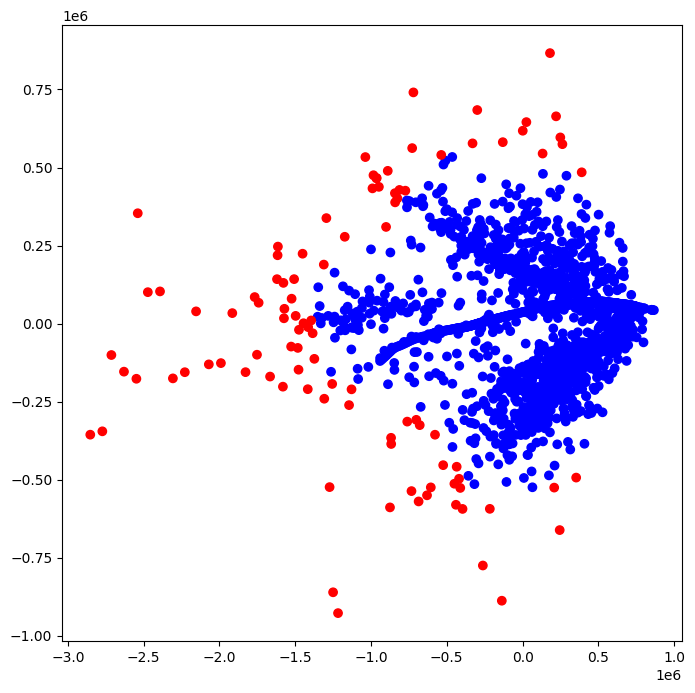

In [10]:
prob_cutoff = 0.98
plt.figure(figsize=(8, 8))
plt.scatter(mds_out[:, 0], mds_out[:, 1], color = np.where(probability > prob_cutoff, 'r', 'b'))